In [1]:
import pandas as pd
from evaluations.evaluation_data.evaluation_data import EvaluationData
from tampering.tampering import Tampering
from timf.timf import TIMF
from data_service.data_service import DataService
import numpy as np


evaluation_data = EvaluationData()
tampering = Tampering()
        
data_service = DataService()
timf = TIMF(data_service)

data = evaluation_data.get_data()


tampering_percentages = list(range(10, 100, 30))

# tampering_types = ["N", "K", "S"]  # Naive, Knowledgeable, Sophisticated
tampering_types = ["N"]
        
results = []

def _haversine_km(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371.0 * c

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def compute_metrics_from_labels(y_true_labels, y_pred_labels):
    """
    Inputs are arrays/Series with values 'T' or 'C'
    """
    y_true = (pd.Series(y_true_labels) == 'T').astype(int)
    y_pred = (pd.Series(y_pred_labels) == 'T').astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)

    try:
        auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc = None

    return accuracy, precision, recall, auc


Loaded existing evaluation data from CSV.


In [4]:
import time
import pandas as pd
import numpy as np

# =====================================================
# CONFIGURATION
# =====================================================

STEP_SIZE = 2500
MAX_SIZE = len(data)

data_sizes = list(range(STEP_SIZE, MAX_SIZE + 1, STEP_SIZE))

runtime_results = []

# =====================================================
# MAIN EXPERIMENT LOOP
# =====================================================

for data_size in data_sizes:

    print(f"\n==============================")
    print(f"Running experiments with data size = {data_size}")
    print(f"==============================")

    # Subsample data for this experiment size
    data_subset = data.sample(
        n=data_size,
        random_state=42
    ).reset_index(drop=True)

    for tampering_type in tampering_types:
        for tampering_percentage in tampering_percentages:

            print(f"Experiment: Tampering Type={tampering_type}, "
                  f"Percentage={tampering_percentage}%")

            for assessing_mic in data_subset['gen_microcell'].unique():

                df_microcell = data_subset[
                    data_subset['gen_microcell'] == assessing_mic
                ]

                # -------- Remote tampering (BMA) --------
                bma_tampered_df = tampering.bma_tampering(
                    data_subset[data_subset['gen_microcell'] != assessing_mic]
                        .reset_index(drop=True),
                    tampering_percentage,
                    tampering_type
                )

                remote_data = bma_tampered_df.copy()

                # -------- Replication logic --------
                microcell_coords = (
                    data_subset
                    .groupby('gen_microcell')[['latitude', 'longitude']]
                    .first()
                    .reset_index()
                )

                current_coords = microcell_coords[
                    microcell_coords['gen_microcell'] == assessing_mic
                ]

                if not current_coords.empty:

                    lat1 = current_coords['latitude'].values[0]
                    lon1 = current_coords['longitude'].values[0]

                    df_microcell_part = df_microcell.copy()
                    df_microcell_part.loc[:, 'currect_microcell'] = assessing_mic

                    replicated_parts = [df_microcell_part]

                    for provider_id in df_microcell['providerid'].unique():

                        provider_remote = remote_data[
                            remote_data['providerid'] == provider_id
                        ]

                        candidate_microcells = []

                        for _, row in microcell_coords.iterrows():
                            if row['gen_microcell'] == assessing_mic:
                                continue
                            if (provider_remote['gen_microcell']
                                == row['gen_microcell']).any():

                                dist = _haversine_km(
                                    lat1, lon1,
                                    row['latitude'], row['longitude']
                                )
                                candidate_microcells.append(
                                    (row['gen_microcell'], dist)
                                )

                        candidate_microcells.sort(key=lambda x: x[1])
                        nearby_microcells = [
                            m for m, _ in candidate_microcells[:10]
                        ]

                        if nearby_microcells:

                            df_remote = remote_data[
                                (remote_data['providerid'] == provider_id) &
                                (remote_data['gen_microcell']
                                 .isin(nearby_microcells))
                            ].drop_duplicates(subset='serviceid')

                            if not df_remote.empty:
                                df_remote['origin'] = 'R'
                                df_remote['currect_microcell'] = assessing_mic
                                replicated_parts.append(df_remote)

                    df_microcell_replicated = pd.concat(
                        replicated_parts, ignore_index=True
                    )

                else:
                    df_microcell_replicated = df_microcell.copy()

                # -------- Local tampering (SPA) --------
                spa_tampered_df = tampering.spa_tampering(
                    df_microcell_replicated,
                    type=tampering_type
                )

                # -------- Set TIMF data --------
                data_service.set_local_data(spa_tampered_df.copy())
                data_service.set_remote_data(
                    data_subset[data_subset['gen_microcell'] != assessing_mic]
                        .copy()
                )

                # =====================================================
                # TRUST ASSESSMENT + RUNTIME MEASUREMENT
                # =====================================================

                for provider in df_microcell['providerid'].unique():

                    # -------- TIMF --------
                    start = time.perf_counter()
                    timf.trust_assessment(provider, assessing_mic)
                    end = time.perf_counter()

                    runtime_results.append({
                        'method': 'TIMF',
                        'dataset_size': data_size,
                        'tampering_type': tampering_type,
                        'tampering_percentage': tampering_percentage,
                        'gen_microcell': assessing_mic,
                        'provider': provider,
                        'time_sec': end - start
                    })

                    # -------- IFUM --------
                    start = time.perf_counter()
                    timf.trust_assessment_baseline_ifum(
                        provider, assessing_mic
                    )
                    end = time.perf_counter()

                    runtime_results.append({
                        'method': 'IFUM',
                        'dataset_size': data_size,
                        'tampering_type': tampering_type,
                        'tampering_percentage': tampering_percentage,
                        'gen_microcell': assessing_mic,
                        'provider': provider,
                        'time_sec': end - start
                    })

                    # -------- LOF --------
                    start = time.perf_counter()
                    timf.trust_assessment_baseline_lof(
                        provider, assessing_mic
                    )
                    end = time.perf_counter()

                    runtime_results.append({
                        'method': 'LOF',
                        'dataset_size': data_size,
                        'tampering_type': tampering_type,
                        'tampering_percentage': tampering_percentage,
                        'gen_microcell': assessing_mic,
                        'provider': provider,
                        'time_sec': end - start
                    })

                    # -------- OCSVM --------
                    start = time.perf_counter()
                    timf.trust_assessment_baseline_ocsvm(
                        provider, assessing_mic
                    )
                    end = time.perf_counter()

                    runtime_results.append({
                        'method': 'OCSVM',
                        'dataset_size': data_size,
                        'tampering_type': tampering_type,
                        'tampering_percentage': tampering_percentage,
                        'gen_microcell': assessing_mic,
                        'provider': provider,
                        'time_sec': end - start
                    })

# =====================================================
# FINAL RESULTS DATAFRAME
# =====================================================

runtime_df = pd.DataFrame(runtime_results)

# Optional: aggregate mean runtime per size & method
runtime_summary = (
    runtime_df
    .groupby(['method', 'dataset_size'])['time_sec']
    .mean()
    .reset_index()
)

print("Runtime benchmarking completed.")



Running experiments with data size = 2500
Experiment: Tampering Type=N, Percentage=10%


python(6870) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Experiment: Tampering Type=N, Percentage=40%
Experiment: Tampering Type=N, Percentage=70%

Running experiments with data size = 5000
Experiment: Tampering Type=N, Percentage=10%
Experiment: Tampering Type=N, Percentage=40%
Experiment: Tampering Type=N, Percentage=70%
Runtime benchmarking completed.


In [3]:
runtime_summary

,method,dataset_size,time_sec
0,IFUM,5000,0.058375
1,LOF,5000,0.001704
2,OCSVM,5000,0.001514
3,TIMF,5000,0.069735


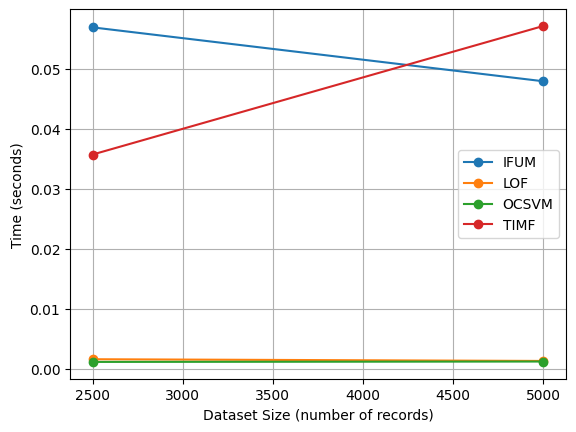

In [6]:
import matplotlib.pyplot as plt

plt.figure()

for method in runtime_summary["method"].unique():
    subset = runtime_summary[runtime_summary["method"] == method]
    plt.plot(subset["dataset_size"], subset["time_sec"],
             marker='o', label=method)

plt.xlabel("Dataset Size (number of records)")
plt.ylabel("Time (seconds)")
plt.legend()
plt.grid(True)
plt.show()
